## Runs DE on different clusters. Also runs DE within each cluster for each condition

In [1]:
#integrated_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/annotation/mergedSamples/allSamples.integrated.rds" 
clones_indir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021//MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones"
outdir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF"
sample_names = "pre,post"
cores = 8

genome = "/data/Mito_Trace/data/external/GRCh38_MT_blacklist/fasta/genome.fa"
comps_f = ""
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"
#cond.comparisons <- "A,preA,postA;B,preB,postB"

In [2]:
source(utils_script)

Attaching SeuratObject



## Libraries

In [3]:
library(motifmatchr)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)



Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: GenomicRanges

Loading required package: Biostrings

Loadin

In [4]:
library(dplyr)

library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union


The following object is masked from ‘package:XVector’:

    slice


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: Annot

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
#clust_outdir = file.path(outdir, "clusters")
#clust_atac_outdir = file.path(outdir, "clusters_atac")
cond_outdir = file.path(outdir, "conditions_clusters")
#cons_outdir = file.path(outdir, "conditions_conserved")
dir.create(outdir, showWarnings = T)
#dir.create(clust_outdir, showWarnings = FALSE)
dir.create(cond_outdir, showWarnings = T)
#dir.create(cons_outdir, showWarnings = FALSE)
#dir.create(clust_atac_outdir, showWarnings = FALSE)

In [6]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
#samples <- unlist(strsplit(samples, ","))

sample_names

[1] "pre"  "post"

In [7]:
# # extract gene annotations from EnsDb
# annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# # change to UCSC style since the data was mapped to hg19
# seqlevelsStyle(annotations) <- 'UCSC'
# genome(annotations) <- "hg38"

# # add the gene information to the object
# Annotation(integrated) <- annotations


# gene.activities <- GeneActivity(integrated)


In [8]:
se <- readRDS(file.path(clones_indir, "SE.rds"))
se$donor.cond = paste0("d", se$donor, se$condition)
se

# integrated <- readRDS(integrated_f)#file.path(indir, paste0("allSamples.integrated.rds")))
# integrated

An object of class Seurat 
98240 features across 19584 samples within 2 assays 
Active assay: RNA (20010 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

In [9]:
se[[]]

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,⋯,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,donor.cond
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<int>,<chr>,<I<chr>>,<fct>,<fct>,<fct>,<fct>,<chr>
pre_AAACGAAAGCCGCAAA-1,pre,4794,4794,38802,9366,247,213,1646,18980,8350,⋯,2,4483,2810,AAACGAAAGCCGCAAA-1_pre,pre_AAACGAAAGCCGCAAA-1,25,1,pre,1_25,d1pre
pre_AAACGAAAGGCTCCTG-1,pre,1887,1887,15412,2697,66,65,444,8994,3146,⋯,5,1593,1336,AAACGAAAGGCTCCTG-1_pre,pre_AAACGAAAGGCTCCTG-1,12,0,pre,0_12,d0pre
pre_AAACGAAAGTAGCAAT-1,pre,3068,3068,19828,5489,201,117,859,8209,4953,⋯,6,2563,1829,AAACGAAAGTAGCAAT-1_pre,pre_AAACGAAAGTAGCAAT-1,29,1,pre,1_29,d1pre
pre_AAACGAAAGTGAATAC-1,pre,1686,1686,11328,2048,58,40,407,6141,2634,⋯,8,1389,1195,AAACGAAAGTGAATAC-1_pre,pre_AAACGAAAGTGAATAC-1,6,0,pre,0_6,d0pre
pre_AAACGAAAGTGTCACT-1,pre,4229,4229,26680,9152,251,163,1499,7181,8434,⋯,7,4425,2949,AAACGAAAGTGTCACT-1_pre,pre_AAACGAAAGTGTCACT-1,5,0,pre,0_5,d0pre
pre_AAACGAACACGGCCAT-1,pre,2054,2054,16145,3572,88,91,684,8514,3196,⋯,1,1698,1328,AAACGAACACGGCCAT-1_pre,pre_AAACGAACACGGCCAT-1,32,1,pre,1_32,d1pre
pre_AAACGAACATAGGCGA-1,pre,3548,3548,34697,8294,154,194,1261,18482,6312,⋯,3,3281,2348,AAACGAACATAGGCGA-1_pre,pre_AAACGAACATAGGCGA-1,26,0,pre,0_26,d0pre
pre_AAACGAACATTAACGC-1,pre,4001,4001,19923,6293,177,104,1353,4963,7033,⋯,6,3934,2573,AAACGAACATTAACGC-1_pre,pre_AAACGAACATTAACGC-1,4,1,pre,1_4,d1pre
pre_AAACGAAGTTAACTCG-1,pre,3580,3580,40203,11082,196,187,1392,20266,7080,⋯,5,3454,2467,AAACGAAGTTAACTCG-1_pre,pre_AAACGAAGTTAACTCG-1,36,0,pre,0_36,d0pre


In [10]:
se[['peak_region_fragments']]

,peak_region_fragments
,<dbl>
pre_AAACGAAAGCCGCAAA-1,6406
pre_AAACGAAAGGCTCCTG-1,2147
pre_AAACGAAAGTAGCAAT-1,3864
pre_AAACGAAAGTGAATAC-1,1854
pre_AAACGAAAGTGTCACT-1,5456
pre_AAACGAACACGGCCAT-1,2480
pre_AAACGAACATAGGCGA-1,4378
pre_AAACGAACATTAACGC-1,5201
pre_AAACGAAGTTAACTCG-1,4393


## UMAP plots

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



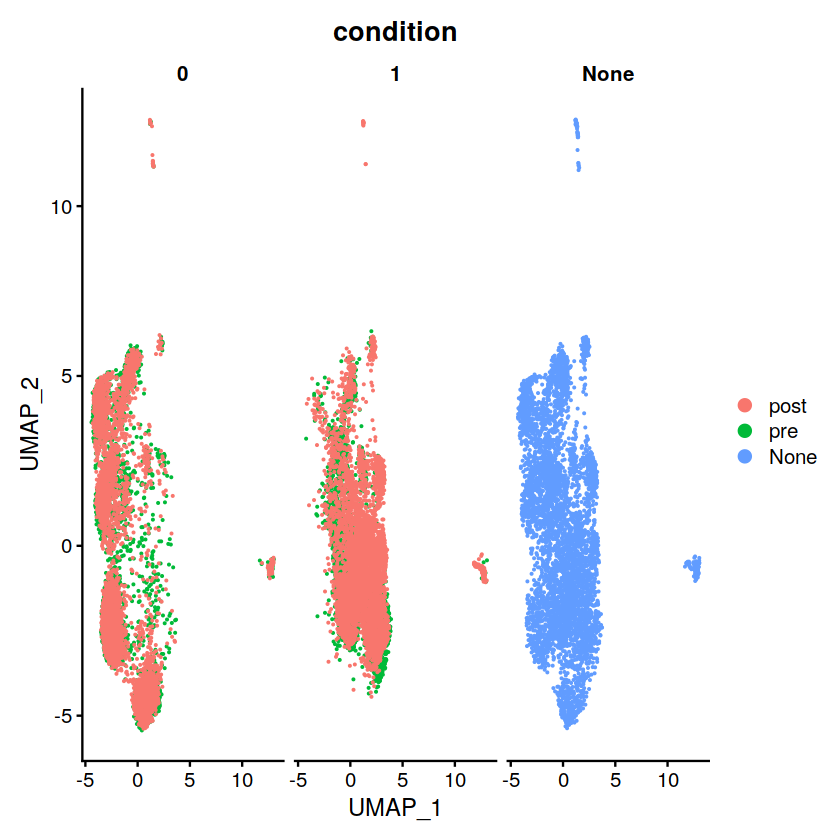

In [11]:
DimPlot(object = se, label = FALSE, split.by=c("donor"), group.by = c('condition'))#, "lineage"))
ggsave(file.path(cond_outdir, "umap.donor.png"))
ggsave(file.path(cond_outdir, "umap.donor.pdf"))

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



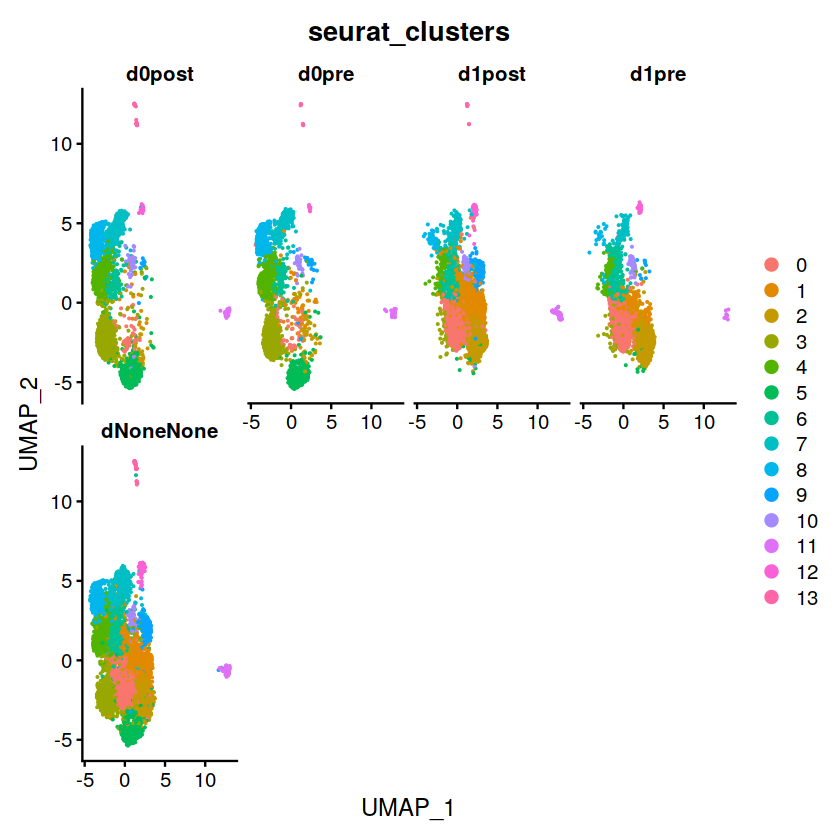

In [12]:
DimPlot(object = se, label = FALSE, split.by=c("donor.cond"), group.by="seurat_clusters",
       ncol=4)#, group.by = c('donor'))
ggsave(file.path(cond_outdir, "umap.donor.conditions.png"))
ggsave(file.path(cond_outdir, "umap.donor.conditions.pdf"))

## Get motifs for se

In [13]:
se <- get.pwm(se, genome=genome)

Building motif matrix

Finding motif positions

Creating Motif object

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [14]:
#DefaultAssay(se) <- 'chromvarnames'

# Get JASPAR TF matrix

In [15]:
# # extract position frequency matrices for the motifs
# pwm <- getMatrixSet(
#   x = JASPAR2020,
#   opts = list(species = 9606, all_versions = FALSE)
# )
# fa.file <- Rsamtools::FaFile(genome, index=sprintf("%s.fai", genome)) #,



# DefaultAssay(se) <- "ATAC"

# chrom.assay <- se[["ATAC"]]

# # add motif information
# chrom.assay <- AddMotifs(chrom.assay, genome = fa.file, pfm = pwm)

# se = SetAssayData(se, slot="motifs", Motifs(chrom.assay) )

# se = RunChromVAR(se, genome=fa.file)

# DefaultAssay(se) <- 'chromvar'

In [16]:
# plotDE <- function(integrated, de.results, i, outdir){
#     try
#     {
#     plot1 <- MotifPlot(object = integrated,
#                        motifs = head(rownames(de.results)),
#                        assay = 'ATAC')
#     plot2 <- FeaturePlot(
#       object = integrated,
#       features = rownames(de.results)[1],
#       pt.size = 0.1
#     )

#     plot3 <- FeaturePlot(
#       object = integrated,
#       features = rownames(de.results)[2],
#       pt.size = 0.1
#     )
    
#     plot2 | plot3
#     ggsave(file.path(outdir,paste0("cluster_",i,".DE.TF.top2.png")))
#     ggsave(file.path(outdir,paste0("cluster_",i,".DE.TF.Motifs.png")))
#     ggsave(file.path(outdir,paste0("cluster_",i,".DE.TF.Motifs.pdf")))
#     return(c(plot1, plot2, plot3))
#     }
#     return
# }

# Stimulus specific response
A. Comparing within-cluster condition differences  
B. Comparing within-cluster and within-donor condition differences  
C. Re-compute clusters for each donor and re-run  
D. Clone enrichment in clusters  
E. Overall pre vs post  

In [17]:
# create.ids <- function(se, cols, clust.col="seurat_clusters"){
#     if (length(cols)==0){
#         Idents(se) = clust.id
#     }else{
#         cols = c(cols, clust.col)
#         se$curr.id <- apply(se[[]][ , cols ] , 1 , paste , collapse = "_" )
#         Idents(se) <- "curr.id"
#     }
#     return(se)
# }

# se = create.ids(se, c("donor"))

In [18]:
# stimout <- function(se, outdir, sample_names, 
#                     sample.id = "condition", cols=c()){
#     clust.ids <- levels(se$seurat_clusters)
#     don.ids <- levels(se$donor)
    
#     #cluster.ids <- sort(unique(se$clust.id))
#     if (length(cols)==0){
#         curr.ids <- as.factor(sample_names)
#         Idents(se) <- as.factor(se$sample.id)
        
#     }else if(length(cols)==1){
#         print('here')
#         curr.ids <- levels(se[[]][[cols]])
#         Idents(se) <- as.factor(apply(se[[]][ , c(sample.id, cols) ] , 1 , paste , collapse = "_" ))
#     }else{
#         curr.ids <- levels(as.factor(apply(se[[]][ , cols ] , 1 , paste , collapse = "_" )))
#         Idents(se) <- as.factor(apply(se[[]][ , c(sample.id, cols) ] , 1 , paste , collapse = "_" ))
#     }
#     se$curr.id = Idents(se)
#     print(head(Idents(se)))
       
#      #<- sort(unique(se$curr.id))
#     for (cl in clust.ids){
#         for (d in don.ids){
#             c <- paste0(sample.id, "_", cl, "_" d)
#             cl.names.sig = c()
#     #for (c in curr.ids){
#             try({
#                 print(c)
#                 if (length(cols)==0){
#                     id1 <- sample_names[[1]]
#                     id2 <- sample_names[[2]]
#                 }else{
#                     print(c)
#                     id1 <- paste(sample_names[[1]], c, sep="_")
#                     id2 <- paste(sample_names[[2]], c, sep="_")
#                 }
#                 DefaultAssay(se) <- "chromvarnames"
#                 se.filt <- subset(se, idents = c(id1,id2))
                
#                 curr.clust = se_filt$seurat_clusters[[1]] #strsplit(c,"_")[[2]]
#                 print(paste0('curr.clust', curr.clust))
#                 curr.donor = se_filt$donor[[1]] #strsplit(c,"_")[[2]]
#                 print(paste0('curr.donor', curr.donor))            

#                 curr.clust.outdir <- file.path(outdir, paste0("clust_", curr.clust))
#                 dir.create(curr.clust.outdir)
#                 curr.outdir <- file.path(curr.clust.outdir, paste0("donor", curr.clust))
#                 dir.create(curr.outdir)

#                 response <- FindMarkers(se,
#                                         ident.1 = id1,
#                                         ident.2 = id2,
#                                         verbose = T,
#                                         only.pos = FALSE,
#                                         mean.fxn = rowMeans,
#                                         logfc.threshold = 0,
#                                         min.pct = 0.01,
#                                         #latent.vars=latent.vars,
#                                         fc.name = "avg_diff")
#                 ncells <- data.frame(table(Idents(se.filt)))
#                 write.csv(ncells, file=file.path(curr.outdir, paste0(c,".counts.csv")), quote=F)
#                 response <- response %>% arrange(p_val)
#                 response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))
#                 print('cleaning de')
#                 names.sig <- clean.de(response, se, n_top_genes, a=id1, b=id2, names.sig = c())
#                 cl.names.sig <- c(cl.names.sig, names.sig)
#                 #response <- curr.de[[1]]
#                 #names.sig <- curr.de[[2]]
#                 print('dim response')
#                 print(dim(response))
#                 if (!(dim(response)[1]==0)){
#                     print('response plots')
#                     print(head(response, n = 3))
#                     de.plots(se.filt, names.sig, curr.outdir, curr.name=c)#paste0(cid1,"_", id2)){

#                     write.csv(response, 
#                               file=file.path(curr.outdir, paste(c,sample_names[[1]], sample_names[[2]],"DE.TF.csv",sep="_")), quote=F)
#                     #plotDE(se, response, c, clust_outdir)

#                     gally <- GGally::ggpairs(response[,c("p_val", "p_val_adj", "avg_diff", "p_val_adj_BH" )], aes(alpha = 0.4))
#                     ggsave(plot=gally, file=file.path(curr.outdir, 
#                                                       paste(c,sample_names[[1]], 
#                                                             sample_names[[2]],".DE.TF.pvalHist.png", sep="_")))

#                 }
#             })
#         }
#     se.filt <- subset(se, seurat_clusters = cl)
#     de.plots(se.filt, cl.names.sig, curr.clust.outdir, curr.name="donorsCombine")#paste0(cid1,"_", id2)){
#     se.avg = AverageExpression(se.filt, assays = "chromvarnames", group.by = "curr.id", features = all.names.sig)$chromvarnames 
#     se.avg = se.avg[order(apply(se.avg, 1, sd)),]
#     write.csv(se.avg, 
#           file=file.path(curr.clust.outdir, "TFactivity.topPvals.txt"), quote=F)
#     }
# }

In [19]:
clean.de <- function(curr.tf.da, se, n_top_genes, a, b, names.sig = c()){
    DefaultAssay(se) <- "ATAC"
    #curr.tf.da <- read.csv(in_f) %>% arrange(p_val)
    print('curr tf de results')
    print(head(curr.tf.da))
    print('curr.tf rownames')
    print(head(row.names(curr.tf.da)))
    curr.sig <- curr.tf.da %>% dplyr::filter(p_val_adj_BH<0.1)
    if (dim(curr.sig)[1]==0){
        curr.sig <- head(curr.tf.da[order(curr.tf.da$p_val),],3)
    }
    print('curr significant motifs')
    print(dim(curr.sig))

    curr.names <- row.names(curr.sig)
    names.sig <- c(names.sig, curr.names)# head(row.names(curr.tf.da), n_top_genes))
    return(names.sig)
}



de.plots <- function(se.filt, names.sig, curr.outdir, curr.name="", max.size=10){
    if (length(names.sig) > max.size){
        names.sig <- names.sig[1:10]
    }
    dot <- DotPlot(se.filt, features = names.sig) + RotatedAxis()

    feat <- FeaturePlot(se.filt,  features=names.sig)
    vln <- VlnPlot(se.filt,  features=names.sig, pt.size = 0)

    # split by a vector
    pdf(file.path(curr.outdir, paste0(curr.name, "heatmap.top.pdf")), width=8,height=8)
    heat <- ComplexHeatmap::Heatmap(GetAssayData(se.filt)[names.sig,], 
            name = curr.name,
            column_split = se.filt[[]]["lineage"],
            show_column_names = FALSE, use_raster=TRUE
           )
    ComplexHeatmap::draw(heat)
    dev.off()
    
    ggsave(plot=feat, 
           file=file.path(curr.outdir, paste0(curr.name,"embedFeat.top.png")))
    ggsave(plot=dot, 
           file=file.path(curr.outdir, paste0(curr.name, "dot.top.png")))
    ggsave(plot=vln, 
           file=file.path(curr.outdir, paste0(curr.name, "violin.top.png")))
    ## pdfs
    ggsave(plot=dot, 
           file=file.path(curr.outdir, paste0(curr.name, "dot.top.pdf")))
    ggsave(plot=vln, 
           file=file.path(curr.outdir, paste0(curr.name, "violin.top.pdf")))
}

In [20]:
#stimout(se, cond_outdir, sample_names, sample.id = "condition", cols=c("seurat_clusters", "donor"))

## Donors analyzed separately

In [21]:
sample.id = "condition"
clust.ids <- levels(se$seurat_clusters)
don.ids <- levels(se$donor)

cols <- c("seurat_clusters", "donor")
curr.ids <- levels(as.factor(apply(se[[]][ , cols ] , 1 , paste , collapse = "_" )))
Idents(se) <- as.factor(apply(se[[]][ , c(sample.id, cols) ] , 1 , paste , collapse = "_" ))
se$curr.id = Idents(se)
print(head(Idents(se)))

for (cl in clust.ids){
    if (cl == "None"){
        next
    }
    for (d in don.ids){
        if (d == "None"){
            print('Skipping None')
            next
        }
        c <- paste0(cl, "_", d)
        cl.names.sig = c()
        
        try({
            print("c")
            print(c)
            if (length(cols)==0){
                id1 <- sample_names[[1]]
                id2 <- sample_names[[2]]
            }else{
                print(c)
                id1 <- paste(sample_names[[1]], c, sep="_")
                id2 <- paste(sample_names[[2]], c, sep="_")
            }
            DefaultAssay(se) <- "chromvarnames"
            se.filt <- subset(se, idents = c(id1,id2))
            curr.clust = se.filt$seurat_clusters[[1]] #strsplit(c,"_")[[2]]
            print(paste0('curr.clust', curr.clust))
            curr.donor = se.filt$donor[[1]] #strsplit(c,"_")[[2]]
            print(paste0('curr.donor', curr.donor))            

            curr.clust.outdir <- file.path(cond_outdir, paste0("clust_", curr.clust))
            dir.create(curr.clust.outdir)
            curr.outdir <- file.path(curr.clust.outdir, paste0("donor", curr.donor))
            dir.create(curr.outdir)

            response <- FindMarkers(se,
                                    ident.1 = id1,
                                    ident.2 = id2,
                                    verbose = T,
                                    only.pos = FALSE,
                                    mean.fxn = rowMeans,
                                    logfc.threshold = 0,
                                    min.pct = 0.01,
                                    #latent.vars=latent.vars,
                                    fc.name = "avg_diff")
            ncells <- data.frame(table(Idents(se.filt)))
            write.csv(ncells, file=file.path(curr.outdir, paste0(c,".counts.csv")), quote=F)
            response <- response %>% arrange(p_val)
            response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))
            print('cleaning de')
            names.sig <- clean.de(response, se, n_top_genes, a=id1, b=id2, names.sig = c())
            cl.names.sig <- c(cl.names.sig, names.sig)
            #response <- curr.de[[1]]
            #names.sig <- curr.de[[2]]
            print('dim response')
            print(dim(response))
            if (!(dim(response)[1]==0)){
                print('response plots')
                print(head(response, n = 3))
                de.plots(se.filt, names.sig, curr.outdir, curr.name=c)#paste0(cid1,"_", id2)){

                write.csv(response, 
                          file=file.path(curr.outdir, paste(c,sample_names[[1]], sample_names[[2]],"DE.TF.csv",sep="_")), quote=F)
                #plotDE(se, response, c, clust_outdir)

                gally <- GGally::ggpairs(response[,c("p_val", "p_val_adj", "avg_diff", "p_val_adj_BH" )], aes(alpha = 0.4))
                ggsave(plot=gally, file=file.path(curr.outdir, 
                                                  paste(c,sample_names[[1]], 
                                                        sample_names[[2]],".DE.TF.pvalHist.png", sep="_")))

            }
        })
    }
    try({
    se.filt <- subset(se, subset = seurat_clusters == cl)
    de.plots(se.filt, cl.names.sig, curr.clust.outdir, curr.name="donorsCombine") #paste0(cid1,"_", id2)){
    se.avg = AverageExpression(se.filt, assays = "chromvarnames", group.by = "curr.id", features = cl.names.sig)$chromvarnames 
    se.avg = se.avg[order(apply(se.avg, 1, sd)),]
    write.csv(se.avg, 
          file=file.path(curr.clust.outdir, "TFactivity.topPvals.txt"), quote=F)
    })
}


pre_AAACGAAAGCCGCAAA-1 pre_AAACGAAAGGCTCCTG-1 pre_AAACGAAAGTAGCAAT-1 
               pre_2_1                pre_5_0                pre_6_1 
pre_AAACGAAAGTGAATAC-1 pre_AAACGAAAGTGTCACT-1 pre_AAACGAACACGGCCAT-1 
               pre_8_0                pre_7_0                pre_1_1 
69 Levels: None_0_None None_1_None None_10_None None_11_None ... pre_9_1
[1] "c"
[1] "0_0"
[1] "0_0"
[1] "curr.clust0"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                          p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
FOSL2::JUND(var.2) 0.0002300992 -0.7851037 0.333 0.694 0.1456528   0.08868602
CLOCK              0.0002802086 -0.8358653 0.271 0.510 0.1773720   0.08868602
JUNB(var.2)        0.0006513821 -0.7401148 0.375 0.673 0.4123249   0.10998820
YY2                0.0008036290  0.6918366 0.667 0.429 0.5086971   0.10998820
FOSB::JUN          0.0008687852 -0.6642674 0.375 0.633 0.5499410   0.10998820
JUND(var.2)        0.0011519150 -0.6418271 0.250 0.612 0.7291622   0.121

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "c"
[1] "0_1"
[1] "0_1"
[1] "curr.clust0"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_0' already exists"


[1] "cleaning de"
[1] "curr tf de results"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
RFX2 2.702271e-47 -0.6665776 0.317 0.590 1.710537e-44 1.054061e-44
RELA 3.330366e-47  0.7566680 0.679 0.437 2.108121e-44 1.054061e-44
RFX4 9.048431e-45 -0.6411774 0.355 0.616 5.727657e-42 1.909219e-42
REL  5.723978e-37  0.6566289 0.667 0.442 3.623278e-34 9.058195e-35
IRF4 6.429459e-34 -0.5569306 0.179 0.377 4.069848e-31 8.139696e-32
RFX5 4.825824e-33 -0.5661803 0.374 0.583 3.054747e-30 5.091244e-31
[1] "curr.tf rownames"
[1] "RFX2" "RELA" "RFX4" "REL"  "IRF4" "RFX5"
[1] "curr significant motifs"
[1] 412   6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
RFX2 2.702271e-47 -0.6665776 0.317 0.590 1.710537e-44 1.054061e-44
RELA 3.330366e-47  0.7566680 0.679 0.437 2.108121e-44 1.054061e-44
RFX4 9.048431e-45 -0.6411774 0.355 0.616 5.727657e-42 1.909219e-42


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "1_0"
[1] "1_0"
[1] "curr.clust1"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                  p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
JDP2        0.007738151 -0.6814661 0.158 0.417         1     0.999546
RARB(var.3) 0.008481945 -0.7048746 0.263 0.500         1     0.999546
THRB(var.2) 0.010163961 -0.5750067 0.281 0.500         1     0.999546
EVX2        0.012136735 -0.6974163 0.298 0.583         1     0.999546
HINFP       0.013244923 -0.5693966 0.439 0.708         1     0.999546
MSANTD3     0.014441639  0.5353966 0.298 0.208         1     0.999546
[1] "curr.tf rownames"
[1] "JDP2"        "RARB(var.3)" "THRB(var.2)" "EVX2"        "HINFP"      
[6] "MSANTD3"    
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
                  p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
JDP2        0.007738151 -0.6814661 0.158 0.417         1     0.999546
RARB(var.3) 0.008481945 -0.7048746 0.263 0.500         1  

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "c"
[1] "1_1"
[1] "1_1"
[1] "curr.clust1"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_1' already exists"


[1] "cleaning de"
[1] "curr tf de results"
                 p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FOS       2.372943e-22 -0.7716869 0.074 0.272 1.502073e-19 1.502073e-19
STAT1     3.370440e-19 -0.5710927 0.280 0.495 2.133489e-16 1.066744e-16
IRF7      3.781579e-18 -0.5002212 0.144 0.364 2.393740e-15 7.979133e-16
BATF      2.581138e-17 -0.6640615 0.092 0.253 1.633861e-14 4.084651e-15
NFE2L1    7.822534e-17 -0.5417457 0.133 0.312 4.951664e-14 8.952172e-15
BATF::JUN 9.324019e-17 -0.6520132 0.077 0.249 5.902104e-14 8.952172e-15
[1] "curr.tf rownames"
[1] "FOS"       "STAT1"     "IRF7"      "BATF"      "NFE2L1"    "BATF::JUN"
[1] "curr significant motifs"
[1] 503   6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FOS   2.372943e-22 -0.7716869 0.074 0.272 1.502073e-19 1.502073e-19
STAT1 3.370440e-19 -0.5710927 0.280 0.495 2.133489e-16 1.066744e-16
IRF7  3.781579e-18 -0.5002212 0.144 0.364 2.393740e-15 7

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "2_0"
[1] "2_0"
[1] "curr.clust2"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                           p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SMAD2::SMAD3::SMAD4 0.0002360282 -0.6212718 0.352 0.627 0.1494058   0.08574463
MYC                 0.0003686634 -0.7302631 0.333 0.686 0.2333639   0.08574463
NR5A1               0.0004063727 -0.5796542 0.241 0.549 0.2572339   0.08574463
REL                 0.0010883593 -0.6932624 0.259 0.471 0.6889314   0.13778628
MYCN                0.0010883593 -0.6039119 0.315 0.627 0.6889314   0.13778628
NEUROG2(var.2)      0.0013929696 -0.6461111 0.315 0.490 0.8817497   0.14695829
[1] "curr.tf rownames"
[1] "SMAD2::SMAD3::SMAD4" "MYC"                 "NR5A1"              
[4] "REL"                 "MYCN"                "NEUROG2(var.2)"     
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
                           p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SMAD2::S

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "2_1"
[1] "2_1"
[1] "curr.clust2"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_2' already exists"


[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
IRF3  7.285623e-41 -0.5591561 0.161 0.382 4.611799e-38 4.611799e-38
IRF8  2.304923e-39 -0.6415014 0.151 0.330 1.459016e-36 7.295080e-37
IRF9  1.108160e-37 -0.5950104 0.148 0.325 7.014651e-35 2.338217e-35
IRF4  3.916359e-37 -0.6363083 0.149 0.329 2.479055e-34 6.197638e-35
IRF2  2.924724e-34 -0.5483081 0.179 0.385 1.851350e-31 3.702700e-32
STAT1 4.469868e-32 -0.5281676 0.265 0.503 2.829427e-29 4.715711e-30
[1] "curr.tf rownames"
[1] "IRF3"  "IRF8"  "IRF9"  "IRF4"  "IRF2"  "STAT1"
[1] "curr significant motifs"
[1] 411   6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
IRF3 7.285623e-41 -0.5591561 0.161 0.382 4.611799e-38 4.611799e-38
IRF8 2.304923e-39 -0.6415014 0.151 0.330 1.459016e-36 7.295080e-37
IRF9 1.108160e-37 -0.5950104 0.148 0.325 7.014651e-35 2.338217e-35


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "3_0"
[1] "3_0"
[1] "curr.clust3"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                 p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BATF      9.357488e-20 -0.4676704 0.176 0.308 5.923290e-17 5.923290e-17
BATF3     2.509290e-19 -0.4561156 0.179 0.316 1.588381e-16 7.369996e-17
BATF::JUN 3.492889e-19 -0.4601949 0.173 0.310 2.210999e-16 7.369996e-17
FOS       9.955193e-19 -0.4499102 0.179 0.290 6.301637e-16 1.575409e-16
ETV4      2.662606e-17 -0.3505023 0.298 0.474 1.685429e-14 3.370859e-15
JDP2      6.874704e-17 -0.4194588 0.182 0.315 4.351688e-14 7.252813e-15
[1] "curr.tf rownames"
[1] "BATF"      "BATF3"     "BATF::JUN" "FOS"       "ETV4"      "JDP2"     
[1] "curr significant motifs"
[1] 437   6
[1] "dim response"
[1] 633   6
[1] "response plots"
                 p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BATF      9.357488e-20 -0.4676704 0.176 0.308 5.923290e-17 5.923290e-17
BATF3     2.509290e-19 -0.4561156 0.179 0.316 1.5883

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "3_1"
[1] "3_1"
[1] "curr.clust3"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_3' already exists"


[1] "cleaning de"
[1] "curr tf de results"
             p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
NFKB1 9.100786e-07 0.8754318 0.681 0.226 0.0005760798 0.0004442507
ERF   1.403636e-06 0.8331096 0.745 0.306 0.0008885014 0.0004442507
FLI1  4.263596e-06 0.8871266 0.702 0.306 0.0026988564 0.0008996188
ETV2  6.048751e-06 0.8367897 0.787 0.387 0.0038288591 0.0009572148
ERG   1.540855e-05 0.8277112 0.702 0.355 0.0097536128 0.0019507226
ETS1  1.921548e-05 0.7799732 0.702 0.387 0.0121633993 0.0020272332
[1] "curr.tf rownames"
[1] "NFKB1" "ERF"   "FLI1"  "ETV2"  "ERG"   "ETS1" 
[1] "curr significant motifs"
[1] 17  6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
NFKB1 9.100786e-07 0.8754318 0.681 0.226 0.0005760798 0.0004442507
ERF   1.403636e-06 0.8331096 0.745 0.306 0.0008885014 0.0004442507
FLI1  4.263596e-06 0.8871266 0.702 0.306 0.0026988564 0.0008996188


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "4_0"
[1] "4_0"
[1] "curr.clust4"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                      p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BHLHE22(var.2) 8.951540e-18 -0.4875950 0.378 0.594 5.666325e-15 5.666325e-15
ELK3           1.665021e-15  0.5009909 0.520 0.315 1.053958e-12 3.648521e-13
ELK1           1.729157e-15  0.4967833 0.517 0.299 1.094556e-12 3.648521e-13
BHLHA15(var.2) 1.660031e-14 -0.4366426 0.434 0.625 1.050799e-11 2.202938e-12
MYOG           1.740078e-14 -0.4626021 0.399 0.613 1.101469e-11 2.202938e-12
E2F2           4.449299e-14  0.5089661 0.657 0.473 2.816406e-11 4.568119e-12
[1] "curr.tf rownames"
[1] "BHLHE22(var.2)" "ELK3"           "ELK1"           "BHLHA15(var.2)"
[5] "MYOG"           "E2F2"          
[1] "curr significant motifs"
[1] 351   6
[1] "dim response"
[1] 633   6
[1] "response plots"
                      p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BHLHE22(var.2) 8.951540e-18 -0.4875950 0.378 0.594

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "4_1"
[1] "4_1"
[1] "curr.clust4"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_4' already exists"


[1] "cleaning de"
[1] "curr tf de results"
             p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
RELA  5.560250e-10 1.1188022 0.897 0.653 3.519638e-07 3.519638e-07
REL   2.057885e-07 0.9572893 0.828 0.653 1.302641e-04 5.781155e-05
KLF5  2.739884e-07 0.4690383 0.770 0.537 1.734347e-04 5.781155e-05
SP1   3.860129e-07 0.5194609 0.770 0.558 2.443462e-04 6.108654e-05
SP4   1.634417e-06 0.5658122 0.724 0.463 1.034586e-03 2.069172e-04
NFKB2 2.381678e-06 0.7851044 0.816 0.653 1.507602e-03 2.512671e-04
[1] "curr.tf rownames"
[1] "RELA"  "REL"   "KLF5"  "SP1"   "SP4"   "NFKB2"
[1] "curr significant motifs"
[1] 70  6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
RELA 5.560250e-10 1.1188022 0.897 0.653 3.519638e-07 3.519638e-07
REL  2.057885e-07 0.9572893 0.828 0.653 1.302641e-04 5.781155e-05
KLF5 2.739884e-07 0.4690383 0.770 0.537 1.734347e-04 5.781155e-05


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "5_0"
[1] "5_0"
[1] "curr.clust5"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                   p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
YY2         2.215934e-10  0.4020012 0.447 0.306 1.402686e-07 1.197942e-07
FOSL2::JUNB 4.112132e-10 -0.4366288 0.273 0.417 2.602980e-07 1.197942e-07
FOSB::JUNB  5.677451e-10 -0.4369633 0.287 0.431 3.593827e-07 1.197942e-07
BACH1       8.659284e-10 -0.4084770 0.297 0.439 5.481327e-07 1.370332e-07
FOSL2::JUND 2.003368e-09 -0.4197552 0.287 0.431 1.268132e-06 2.536263e-07
FOS::JUN    4.801461e-09 -0.4014957 0.283 0.434 3.039325e-06 5.065542e-07
[1] "curr.tf rownames"
[1] "YY2"         "FOSL2::JUNB" "FOSB::JUNB"  "BACH1"       "FOSL2::JUND"
[6] "FOS::JUN"   
[1] "curr significant motifs"
[1] 319   6
[1] "dim response"
[1] 633   6
[1] "response plots"
                   p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
YY2         2.215934e-10  0.4020012 0.447 0.306 1.402686e-07 1.197942e-07
FOSL2::JUNB 4.1121

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "5_1"
[1] "5_1"
[1] "curr.clust5"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_5' already exists"


[1] "cleaning de"
[1] "curr tf de results"
                          p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ETS2                0.001404301  1.1058406  0.75 0.333 0.8889224    0.2799474
SMAD2::SMAD3::SMAD4 0.002270615  0.8151149  0.80 0.292 1.0000000    0.2799474
STAT1               0.002270615 -1.0415920  0.15 0.458 1.0000000    0.2799474
CREB3L1             0.002270615  1.1174953  0.85 0.375 1.0000000    0.2799474
TBX20               0.002654029  0.7570173  0.65 0.292 1.0000000    0.2799474
KLF5                0.002867149  0.4529393  0.70 0.375 1.0000000    0.2799474
[1] "curr.tf rownames"
[1] "ETS2"                "SMAD2::SMAD3::SMAD4" "STAT1"              
[4] "CREB3L1"             "TBX20"               "KLF5"               
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
                          p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ETS2                0.001404301  1.1058406  0.75 0.333 0.8889224    0.2799474
SM

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "6_0"
[1] "6_0"
[1] "curr.clust6"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
GATA5  9.734207e-08 -0.6118112 0.271 0.566 6.161753e-05 4.160240e-05
ZSCAN4 1.314452e-07 -0.6738451 0.169 0.426 8.320479e-05 4.160240e-05
TCF7   3.879973e-07 -0.7471279 0.297 0.485 2.456023e-04 8.186744e-05
LEF1   1.827174e-06 -0.6195478 0.203 0.471 1.156601e-03 2.891503e-04
ZNF317 4.967263e-06 -0.5706925 0.339 0.588 3.144277e-03 6.288555e-04
ETV4   8.529892e-06 -0.4939470 0.263 0.449 5.399422e-03 7.837445e-04
[1] "curr.tf rownames"
[1] "GATA5"  "ZSCAN4" "TCF7"   "LEF1"   "ZNF317" "ETV4"  
[1] "curr significant motifs"
[1] 212   6
[1] "dim response"
[1] 633   6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
GATA5  9.734207e-08 -0.6118112 0.271 0.566 6.161753e-05 4.160240e-05
ZSCAN4 1.314452e-07 -0.6738451 0.169 0.426 8.320479e-05 4.160240e-05
TCF7   3.879973e-07 -0.74712

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "6_1"
[1] "6_1"
[1] "curr.clust6"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_6' already exists"


[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SP1   3.507334e-10  0.3386808 0.816 0.737 2.220142e-07 2.220142e-07
RFX2  1.762313e-09 -0.5586815 0.405 0.598 1.115544e-06 4.604912e-07
ATF2  2.877494e-09  0.5265629 0.670 0.474 1.821454e-06 4.604912e-07
ATF3  2.909897e-09  0.5284663 0.667 0.481 1.841965e-06 4.604912e-07
IRF3  4.760392e-09 -0.4759956 0.466 0.673 3.013328e-06 6.026657e-07
CREB1 6.899287e-09  0.5089739 0.667 0.470 4.367249e-06 7.278748e-07
[1] "curr.tf rownames"
[1] "SP1"   "RFX2"  "ATF2"  "ATF3"  "IRF3"  "CREB1"
[1] "curr significant motifs"
[1] 173   6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SP1  3.507334e-10  0.3386808 0.816 0.737 2.220142e-07 2.220142e-07
RFX2 1.762313e-09 -0.5586815 0.405 0.598 1.115544e-06 4.604912e-07
ATF2 2.877494e-09  0.5265629 0.670 0.474 1.821454e-06 4.604912e-07


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "7_0"
[1] "7_0"
[1] "curr.clust7"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                    p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
LEF1         8.917892e-19 -0.6632956 0.175 0.373 5.645025e-16 5.645025e-16
TCF7L2       4.982978e-15 -0.6471786 0.146 0.310 3.154225e-12 1.577113e-12
TCF7L1       4.514331e-14 -0.5320210 0.256 0.452 2.857571e-11 9.525238e-12
TCF7         4.930021e-13 -0.5837227 0.175 0.360 3.120703e-10 7.801759e-11
TCF4         9.770754e-13 -0.4834726 0.269 0.458 6.184887e-10 1.236977e-10
ASCL1(var.2) 2.765111e-12 -0.4827769 0.317 0.489 1.750315e-09 2.917192e-10
[1] "curr.tf rownames"
[1] "LEF1"         "TCF7L2"       "TCF7L1"       "TCF7"         "TCF4"        
[6] "ASCL1(var.2)"
[1] "curr significant motifs"
[1] 347   6
[1] "dim response"
[1] 633   6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
LEF1   8.917892e-19 -0.6632956 0.175 0.373 5.645025e-16 5.645025e-16
TCF7L2 4.982978

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "7_1"
[1] "7_1"
[1] "curr.clust7"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_7' already exists"


[1] "cleaning de"
[1] "curr tf de results"
                          p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
CREB1              2.610562e-07 0.7344609 0.889 0.577 0.0001652486 7.136932e-05
KLF11              3.044519e-07 0.5111560 0.899 0.658 0.0001927181 7.136932e-05
FOSL1::JUN(var.2)  3.382432e-07 0.8241839 0.758 0.557 0.0002141080 7.136932e-05
FOSL2::JUND(var.2) 7.815493e-07 0.8036989 0.727 0.443 0.0004947207 1.115858e-04
JDP2(var.2)        8.814045e-07 0.7932054 0.758 0.523 0.0005579291 1.115858e-04
FOSL2::JUNB(var.2) 1.260207e-06 0.8412889 0.687 0.477 0.0007977109 1.329518e-04
[1] "curr.tf rownames"
[1] "CREB1"              "KLF11"              "FOSL1::JUN(var.2)" 
[4] "FOSL2::JUND(var.2)" "JDP2(var.2)"        "FOSL2::JUNB(var.2)"
[1] "curr significant motifs"
[1] 168   6
[1] "dim response"
[1] 633   6
[1] "response plots"
                         p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
CREB1             2.610562e-07 0.7344609 0.889 0.577 0.0001652486 7

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "8_0"
[1] "8_0"
[1] "curr.clust8"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
LEF1   3.643018e-09 -0.3626081 0.267 0.412 2.306030e-06 2.306030e-06
TCF7L2 1.453815e-08 -0.3678872 0.232 0.357 9.202650e-06 4.601325e-06
YY2    1.471512e-07  0.3758242 0.481 0.325 9.314674e-05 3.104891e-05
TCF7   2.743497e-07 -0.3528381 0.293 0.406 1.736633e-04 3.797098e-05
ETV1   2.999288e-07 -0.3309426 0.487 0.641 1.898549e-04 3.797098e-05
FERD3L 5.329357e-07 -0.3283636 0.416 0.552 3.373483e-04 5.058342e-05
[1] "curr.tf rownames"
[1] "LEF1"   "TCF7L2" "YY2"    "TCF7"   "ETV1"   "FERD3L"
[1] "curr significant motifs"
[1] 203   6
[1] "dim response"
[1] 633   6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
LEF1   3.643018e-09 -0.3626081 0.267 0.412 2.306030e-06 2.306030e-06
TCF7L2 1.453815e-08 -0.3678872 0.232 0.357 9.202650e-06 4.601325e-06
YY2    1.471512e-07  0.37582

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "8_1"
[1] "8_1"
[1] "curr.clust8"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_8' already exists"


[1] "cleaning de"
[1] "curr tf de results"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
REL    4.715762e-07 1.7297988 1.000 0.755 0.0002985077 0.0002985077
RELA   1.960199e-05 1.5486699 1.000 0.673 0.0124080612 0.0062040306
TBX6   7.929216e-05 1.0362452 0.808 0.429 0.0501919369 0.0167306456
FOXG1  2.050246e-04 0.8589552 0.923 0.469 0.1297805811 0.0210795575
ZNF263 2.050246e-04 0.5738662 0.885 0.551 0.1297805811 0.0210795575
CREB1  2.442518e-04 0.8792728 0.808 0.490 0.1546113755 0.0210795575
[1] "curr.tf rownames"
[1] "REL"    "RELA"   "TBX6"   "FOXG1"  "ZNF263" "CREB1" 
[1] "curr significant motifs"
[1] 31  6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
REL  4.715762e-07 1.729799 1.000 0.755 0.0002985077 0.0002985077
RELA 1.960199e-05 1.548670 1.000 0.673 0.0124080612 0.0062040306
TBX6 7.929216e-05 1.036245 0.808 0.429 0.0501919369 0.0167306456


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "9_0"
[1] "9_0"
[1] "curr.clust9"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
CTCF   0.0002097135 1.3799077 0.958 0.500 0.1327487   0.09995622
MAFF   0.0004227634 1.0356866 0.750 0.214 0.2676092   0.09995622
OTX1   0.0004737262 1.1494876 0.833 0.357 0.2998687   0.09995622
E2F4   0.0014101021 1.2402647 0.458 0.143 0.8925946   0.21976347
HNF1A  0.0017358884 1.0128061 0.833 0.500 1.0000000   0.21976347
POU4F1 0.0023558376 0.9484007 0.917 0.571 1.0000000   0.24854087
[1] "curr.tf rownames"
[1] "CTCF"   "MAFF"   "OTX1"   "E2F4"   "HNF1A"  "POU4F1"
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
CTCF 0.0002097135 1.379908 0.958 0.500 0.1327487   0.09995622
MAFF 0.0004227634 1.035687 0.750 0.214 0.2676092   0.09995622
OTX1 0.0004737262 1.149488 0.833 0.357 0.2998687   0.09995622


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "9_1"
[1] "9_1"
[1] "curr.clust9"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_9' already exists"


[1] "cleaning de"
[1] "curr tf de results"
                          p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ATF7               0.0002704643  1.4169296   0.5 0.136 0.1712039    0.1287999
JUN::JUNB(var.2)   0.0005192332  1.0644172   0.4 0.124 0.3286746    0.1287999
FOSL2::JUND(var.2) 0.0006389231  1.2883025   0.4 0.162 0.4044383    0.1287999
FOSL2::JUNB(var.2) 0.0010023917  1.2111054   0.5 0.179 0.6345139    0.1287999
MAFF               0.0010362180 -0.9184025   0.1 0.647 0.6559260    0.1287999
CREM               0.0014531470  1.0223727   0.5 0.156 0.9198421    0.1287999
[1] "curr.tf rownames"
[1] "ATF7"               "JUN::JUNB(var.2)"   "FOSL2::JUND(var.2)"
[4] "FOSL2::JUNB(var.2)" "MAFF"               "CREM"              
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
                          p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ATF7               0.0002704643 1.416930   0.5 0.136 0.1712039    0.1287999
JUN::JUNB(va

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "10_0"
[1] "10_0"
[1] "curr.clust10"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                  p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
CEBPB       0.001424160 -0.6274765 0.314 0.615 0.9014935    0.4538979
CEBPE       0.002029794 -0.6156373 0.314 0.615 1.0000000    0.4538979
HIF1A       0.002151175  0.6267976 0.714 0.442 1.0000000    0.4538979
ARNT::HIF1A 0.003786665  0.5738432 0.743 0.462 1.0000000    0.5065059
TFAP2C      0.004000836 -0.4638258 0.371 0.654 1.0000000    0.5065059
TFAP2B      0.004839847 -0.4698710 0.371 0.654 1.0000000    0.5106038
[1] "curr.tf rownames"
[1] "CEBPB"       "CEBPE"       "HIF1A"       "ARNT::HIF1A" "TFAP2C"     
[6] "TFAP2B"     
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
CEBPB 0.001424160 -0.6274765 0.314 0.615 0.9014935    0.4538979
CEBPE 0.002029794 -0.6156373 0.314 0.615 1.0000000    0.4538979
HIF

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "10_1"
[1] "10_1"
[1] "curr.clust10"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_10' already exists"


[1] "cleaning de"
[1] "curr tf de results"
                        p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
JUN::JUNB(var.2) 7.820845e-07 0.9595301 0.770 0.477 0.0004950595 0.0004950595
KLF16            2.809928e-06 0.5869148 0.885 0.628 0.0017786841 0.0006160760
NFKB2            2.919791e-06 0.8088675 0.770 0.442 0.0018482279 0.0006160760
KLF5             5.057874e-06 0.4405917 0.836 0.523 0.0032016344 0.0006275188
CREB1            5.450724e-06 0.8316634 0.787 0.465 0.0034503085 0.0006275188
KLF11            6.095226e-06 0.5609686 0.869 0.605 0.0038582783 0.0006275188
[1] "curr.tf rownames"
[1] "JUN::JUNB(var.2)" "KLF16"            "NFKB2"            "KLF5"            
[5] "CREB1"            "KLF11"           
[1] "curr significant motifs"
[1] 71  6
[1] "dim response"
[1] 633   6
[1] "response plots"
                        p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
JUN::JUNB(var.2) 7.820845e-07 0.9595301 0.770 0.477 0.0004950595 0.0004950595
KLF16            2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "11_0"
[1] "11_0"
[1] "curr.clust11"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                           p_val   avg_diff pct.1 pct.2   p_val_adj
SMAD2::SMAD3::SMAD4 2.586715e-06 -0.9065163 0.130 0.433 0.001637390
ZBTB18              6.885753e-06 -0.8792922 0.478 0.800 0.004358682
NFE2L1              1.761110e-05 -0.9110839 0.283 0.600 0.011147823
FOSL2               2.151247e-05 -0.8128964 0.130 0.450 0.013617393
FOS::JUN            3.567443e-05 -0.9069947 0.196 0.517 0.022581917
JUNB                5.685949e-05 -0.8499946 0.326 0.633 0.035992059
                    p_val_adj_BH
SMAD2::SMAD3::SMAD4  0.001637390
ZBTB18               0.002179341
NFE2L1               0.003404348
FOSL2                0.003404348
FOS::JUN             0.004516383
JUNB                 0.005109992
[1] "curr.tf rownames"
[1] "SMAD2::SMAD3::SMAD4" "ZBTB18"              "NFE2L1"             
[4] "FOSL2"               "FOS::JUN"            "JUNB"               
[1] "curr significan

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "11_1"
[1] "11_1"
[1] "curr.clust11"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_11' already exists"


[1] "cleaning de"
[1] "curr tf de results"
                          p_val avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
JUND(var.2)        3.796017e-05 1.630639 1.000 0.478 0.02402878   0.02020539
CREB3L4(var.2)     1.328404e-04 1.894524 1.000 0.433 0.08408794   0.02020539
GMEB2              2.346948e-04 1.300252 1.000 0.656 0.14856179   0.02020539
FOSL2::JUND(var.2) 2.346948e-04 1.859098 1.000 0.556 0.14856179   0.02020539
ATF2               2.346948e-04 1.785806 0.875 0.367 0.14856179   0.02020539
CREB1              2.346948e-04 1.693912 1.000 0.467 0.14856179   0.02020539
[1] "curr.tf rownames"
[1] "JUND(var.2)"        "CREB3L4(var.2)"     "GMEB2"             
[4] "FOSL2::JUND(var.2)" "ATF2"               "CREB1"             
[1] "curr significant motifs"
[1] 29  6
[1] "dim response"
[1] 633   6
[1] "response plots"
                      p_val avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
JUND(var.2)    3.796017e-05 1.630639     1 0.478 0.02402878   0.02020539
CREB3L4(var.2) 1.328404

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "12_0"
[1] "12_0"
[1] "curr.clust12"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
                   p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
EN1          0.002697159 -1.001923 0.429 1.000         1    0.3934665
PDX1         0.002697159 -1.005751 0.000 0.833         1    0.3934665
TCF12(var.2) 0.004636404 -1.427082 0.000 0.333         1    0.3934665
TCF3         0.004636404 -1.372883 0.000 0.333         1    0.3934665
RELA         0.006018875 -1.597783 0.143 0.750         1    0.3934665
DRGX         0.006018875 -1.088653 0.286 0.833         1    0.3934665
[1] "curr.tf rownames"
[1] "EN1"          "PDX1"         "TCF12(var.2)" "TCF3"         "RELA"        
[6] "DRGX"        
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
                   p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
EN1          0.002697159 -1.001923 0.429 1.000         1    0.3934665
PDX1         0.002697159 -1.005751 0.000 0.833   

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "c"
[1] "12_1"
[1] "12_1"
[1] "curr.clust12"
[1] "curr.donor1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_12' already exists"


[1] "cleaning de"
[1] "curr tf de results"
                  p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
JUN        5.005391e-06  1.318005 0.962 0.566 0.003168412  0.001934594
CTCF       1.042995e-05 -1.080597 0.077 0.396 0.006602158  0.001934594
ATF2       1.389824e-05  1.286609 0.923 0.717 0.008797585  0.001934594
FOSL2::JUN 1.457406e-05  1.491157 1.000 0.887 0.009225382  0.001934594
FOSL1      1.528116e-05  1.459457 0.962 0.849 0.009672972  0.001934594
RUNX2      2.802315e-05  1.027763 0.885 0.415 0.017738656  0.002956443
[1] "curr.tf rownames"
[1] "JUN"        "CTCF"       "ATF2"       "FOSL2::JUN" "FOSL1"     
[6] "RUNX2"     
[1] "curr significant motifs"
[1] 96  6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
JUN  5.005391e-06  1.318005 0.962 0.566 0.003168412  0.001934594
CTCF 1.042995e-05 -1.080597 0.077 0.396 0.006602158  0.001934594
ATF2 1.389824e-05  1.286609 0.923 0.717 0.008797585  0.001934594

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Skipping None"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "13_0"
[1] "13_0"
[1] "curr.clust13"
[1] "curr.donor0"
[1] "cleaning de"
[1] "curr tf de results"
             p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
E2F6  0.0002064298 1.0440704     1 0.905 0.1306700    0.1206045
LHX2  0.0004926270 1.6627622     1 0.857 0.3118329    0.1206045
KLF5  0.0006882409 0.9248657     1 0.762 0.4356565    0.1206045
KLF15 0.0008111408 1.4477358     1 1.000 0.5134521    0.1206045
E2F1  0.0009541495 1.1867726     1 0.524 0.6039767    0.1206045
E2F2  0.0015352333 1.1486797     1 0.619 0.9718027    0.1386096
[1] "curr.tf rownames"
[1] "E2F6"  "LHX2"  "KLF5"  "KLF15" "E2F1"  "E2F2" 
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 632   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
E2F6 0.0002064298 1.0440704     1 0.905 0.1306700    0.1206045
LHX2 0.0004926270 1.6627622     1 0.857 0.3118329    0.1206045
KLF5 0.0006882409 0.9248657     1 0.762 0.4356565    0.1206045


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "c"
[1] "13_1"
[1] "13_1"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: pre_13_1
[1] "Skipping None"
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 


## All donors in each cluster

In [22]:
curr.ids <- clust.ids
Idents(se) <- as.factor(apply(se[[]][ , c("condition", "seurat_clusters") ] , 1 , paste , collapse = "_" ))
se$curr.id = Idents(se)

for (cl in clust.ids)
    {
    if (cl == "None"){
        next
    }
    c <- cl
    
    id1 <- paste(sample_names[[1]], cl, sep="_")
    id2 <- paste(sample_names[[2]], cl, sep="_")
    
    DefaultAssay(se) <- "chromvarnames"
    se.filt <- subset(se, idents = c(id1,id2))
    curr.clust = se.filt$seurat_clusters[[1]] #strsplit(c,"_")[[2]]
    print(paste0('curr.clust', curr.clust))
    
    curr.clust.outdir <- file.path(cond_outdir, paste0("clust_", curr.clust))
    curr.outdir <- file.path(curr.clust.outdir, "allDonors")
    dir.create(curr.outdir)

    response <- FindMarkers(se,
                            ident.1 = id1,
                            ident.2 = id2,
                            verbose = T,
                            only.pos = FALSE,
                            mean.fxn = rowMeans,
                            logfc.threshold = 0,
                            min.pct = 0.01,
                            #latent.vars=latent.vars,
                            fc.name = "avg_diff")
    ncells <- data.frame(table(Idents(se.filt)))
    write.csv(ncells, file=file.path(curr.outdir, paste0(c,".counts.csv")), quote=F)
    response <- response %>% arrange(p_val)
    response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))
    print('cleaning de')
    names.sig <- clean.de(response, se, n_top_genes, a=id1, b=id2, names.sig = c())
    #cl.names.sig <- c(cl.names.sig, names.sig)
    #response <- curr.de[[1]]
    #names.sig <- curr.de[[2]]
    print('dim response')
    print(dim(response))
    if (!(dim(response)[1]==0)){
        print('response plots')
        print(head(response, n = 3))
        de.plots(se.filt, names.sig, curr.outdir, curr.name=c)#paste0(cid1,"_", id2)){

        write.csv(response, 
                  file=file.path(curr.outdir, paste(c,sample_names[[1]], sample_names[[2]],"DE.TF.csv",sep="_")), quote=F)
        #plotDE(se, response, c, clust_outdir)

        gally <- GGally::ggpairs(response[,c("p_val", "p_val_adj", "avg_diff", "p_val_adj_BH" )], aes(alpha = 0.4))
        ggsave(plot=gally, file=file.path(curr.outdir, 
                                          paste(c,sample_names[[1]], 
                                                sample_names[[2]],".DE.TF.pvalHist.png", sep="_")))


        se.avg = AverageExpression(se.filt, assays = "chromvarnames", group.by = "condition", 
                                   features = names.sig)$chromvarnames 
        se.avg = se.avg[order(apply(se.avg, 1, sd)),]
        write.csv(se.avg, file=file.path(curr.outdir, "TFactivity.topPvals.txt"), quote=F)
    }
}




[1] "curr.clust0"
[1] "cleaning de"
[1] "curr tf de results"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
RFX2 7.260535e-47 -0.6500410 0.322 0.586 4.595919e-44 4.595919e-44
RFX4 5.829661e-43 -0.6161562 0.366 0.613 3.690176e-40 1.845088e-40
RELA 7.457936e-42  0.7046523 0.657 0.432 4.720873e-39 1.573624e-39
REL  2.607196e-33  0.6109807 0.652 0.440 1.650355e-30 4.125887e-31
RFX5 9.262069e-33 -0.5515049 0.378 0.581 5.862890e-30 1.172578e-30
IRF4 1.339054e-29 -0.5078026 0.194 0.374 8.476214e-27 1.412702e-27
[1] "curr.tf rownames"
[1] "RFX2" "RFX4" "RELA" "REL"  "RFX5" "IRF4"
[1] "curr significant motifs"
[1] 410   6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
RFX2 7.260535e-47 -0.6500410 0.322 0.586 4.595919e-44 4.595919e-44
RFX4 5.829661e-43 -0.6161562 0.366 0.613 3.690176e-40 1.845088e-40
RELA 7.457936e-42  0.7046523 0.657 0.432 4.720873e-39 1.573624e-39


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust1"
[1] "cleaning de"
[1] "curr tf de results"
                 p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FOS       2.122082e-20 -0.6759043 0.101 0.275 1.343278e-17 1.343278e-17
STAT1     1.654705e-19 -0.5279512 0.287 0.492 1.047428e-16 5.237141e-17
BATF      1.920686e-17 -0.6188733 0.116 0.254 1.215794e-14 4.052647e-15
BATF::JUN 8.863974e-17 -0.6042083 0.101 0.250 5.610896e-14 1.402724e-14
BATF3     1.198735e-16 -0.6063488 0.119 0.259 7.587990e-14 1.517598e-14
NFE2L1    1.030376e-15 -0.4855639 0.162 0.314 6.522279e-13 1.087047e-13
[1] "curr.tf rownames"
[1] "FOS"       "STAT1"     "BATF"      "BATF::JUN" "BATF3"     "NFE2L1"   
[1] "curr significant motifs"
[1] 537   6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FOS   2.122082e-20 -0.6759043 0.101 0.275 1.343278e-17 1.343278e-17
STAT1 1.654705e-19 -0.5279512 0.287 0.492 1.047428e-16 5.237141e-17
BATF  1.920686e-17 -0.6188733 0.116 0.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust2"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
IRF3  4.624013e-36 -0.5091792 0.183 0.385 2.927000e-33 2.927000e-33
IRF8  1.294107e-34 -0.5902237 0.173 0.338 8.191695e-32 4.095847e-32
IRF4  4.612430e-34 -0.5885662 0.166 0.335 2.919668e-31 9.732228e-32
IRF9  4.789726e-33 -0.5443508 0.174 0.335 3.031896e-30 7.579741e-31
RFX2  4.001144e-31 -0.5715615 0.365 0.599 2.532724e-28 5.065448e-29
STAT1 5.868072e-31 -0.4967517 0.276 0.507 3.714490e-28 6.190816e-29
[1] "curr.tf rownames"
[1] "IRF3"  "IRF8"  "IRF4"  "IRF9"  "RFX2"  "STAT1"
[1] "curr significant motifs"
[1] 410   6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
IRF3 4.624013e-36 -0.5091792 0.183 0.385 2.927000e-33 2.927000e-33
IRF8 1.294107e-34 -0.5902237 0.173 0.338 8.191695e-32 4.095847e-32
IRF4 4.612430e-34 -0.5885662 0.166 0.335 2.919668e-31 9.732228e-32


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust3"
[1] "cleaning de"
[1] "curr tf de results"
                 p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BATF      4.540022e-21 -0.4658119 0.167 0.301 2.873834e-18 2.873834e-18
BATF::JUN 1.607245e-20 -0.4581184 0.166 0.303 1.017386e-17 5.086931e-18
BATF3     3.881026e-20 -0.4493954 0.173 0.311 2.456689e-17 8.188965e-18
FOS       1.792850e-19 -0.4426339 0.176 0.285 1.134874e-16 2.837186e-17
JDP2      1.540910e-17 -0.4103373 0.178 0.311 9.753960e-15 1.950792e-15
FOSL1     2.258035e-16 -0.4004948 0.169 0.299 1.429336e-13 2.382227e-14
[1] "curr.tf rownames"
[1] "BATF"      "BATF::JUN" "BATF3"     "FOS"       "JDP2"      "FOSL1"    
[1] "curr significant motifs"
[1] 430   6
[1] "dim response"
[1] 633   6
[1] "response plots"
                 p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BATF      4.540022e-21 -0.4658119 0.167 0.301 2.873834e-18 2.873834e-18
BATF::JUN 1.607245e-20 -0.4581184 0.166 0.303 1.017386e-17 5.086931e-18
BATF3     3.881026e-20 -0.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust4"
[1] "cleaning de"
[1] "curr tf de results"
                      p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BHLHE22(var.2) 1.599511e-16 -0.4261738 0.403 0.595 1.012490e-13 1.012490e-13
ELK1           6.092668e-16  0.4893369 0.521 0.325 3.856659e-13 1.928329e-13
ELK3           1.238142e-15  0.4847351 0.535 0.345 7.837436e-13 2.612479e-13
MYOG           3.940157e-13 -0.4020447 0.419 0.603 2.494120e-10 6.235299e-11
YY2            2.713522e-12  0.4403175 0.554 0.408 1.717659e-09 3.435319e-10
FEV            1.078383e-11  0.3785239 0.558 0.362 6.826164e-09 1.137694e-09
[1] "curr.tf rownames"
[1] "BHLHE22(var.2)" "ELK1"           "ELK3"           "MYOG"          
[5] "YY2"            "FEV"           
[1] "curr significant motifs"
[1] 317   6
[1] "dim response"
[1] 633   6
[1] "response plots"
                      p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BHLHE22(var.2) 1.599511e-16 -0.4261738 0.403 0.595 1.012490e-13 1.012490e-13
ELK1           6.09

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust5"
[1] "cleaning de"
[1] "curr tf de results"
                   p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
YY2         2.865283e-11  0.4101771 0.454 0.311 1.813724e-08 1.813724e-08
FOSL2::JUNB 1.785380e-10 -0.4362772 0.277 0.421 1.130146e-07 5.650728e-08
FOSB::JUNB  3.514817e-10 -0.4334109 0.290 0.437 2.224879e-07 7.416265e-08
FOSL2::JUND 7.709659e-10 -0.4180150 0.290 0.435 4.880214e-07 1.220053e-07
BACH1       2.611781e-09 -0.3912704 0.306 0.442 1.653257e-06 3.306514e-07
FOS::JUN    3.619886e-09 -0.3955775 0.290 0.437 2.291388e-06 3.818979e-07
[1] "curr.tf rownames"
[1] "YY2"         "FOSL2::JUNB" "FOSB::JUNB"  "FOSL2::JUND" "BACH1"      
[6] "FOS::JUN"   
[1] "curr significant motifs"
[1] 298   6
[1] "dim response"
[1] 633   6
[1] "response plots"
                   p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
YY2         2.865283e-11  0.4101771 0.454 0.311 1.813724e-08 1.813724e-08
FOSL2::JUNB 1.785380e-10 -0.4362772 0.277 0.421 1.130146e-07 5.6

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust6"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SP1   5.565812e-09  0.2846421 0.742 0.657 3.523159e-06 3.523159e-06
SP4   9.602747e-08  0.2723757 0.719 0.575 6.078539e-05 3.039269e-05
RFX1  3.539775e-07 -0.3432086 0.421 0.590 2.240677e-04 7.468925e-05
RFX3  1.512771e-06 -0.3113844 0.425 0.572 9.575842e-04 2.393960e-04
KLF14 2.569084e-06  0.2613946 0.685 0.575 1.626230e-03 3.252460e-04
IRF3  4.881806e-06 -0.3330193 0.494 0.622 3.090183e-03 5.150305e-04
[1] "curr.tf rownames"
[1] "SP1"   "SP4"   "RFX1"  "RFX3"  "KLF14" "IRF3" 
[1] "curr significant motifs"
[1] 129   6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SP1  5.565812e-09  0.2846421 0.742 0.657 3.523159e-06 3.523159e-06
SP4  9.602747e-08  0.2723757 0.719 0.575 6.078539e-05 3.039269e-05
RFX1 3.539775e-07 -0.3432086 0.421 0.590 2.240677e-04 7.468925e-05


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust7"
[1] "cleaning de"
[1] "curr tf de results"
                      p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
LEF1           5.747341e-15 -0.5078972 0.221 0.380 3.638067e-12 3.638067e-12
TCF7L2         2.309694e-14 -0.5361697 0.176 0.336 1.462036e-11 7.310180e-12
TCF7L1         6.553566e-12 -0.4320010 0.316 0.486 4.148407e-09 1.382802e-09
TCF7           2.947104e-10 -0.4358865 0.221 0.361 1.865517e-07 4.030243e-08
TCF4           3.183447e-10 -0.3613495 0.311 0.454 2.015122e-07 4.030243e-08
BHLHE22(var.2) 1.481516e-09 -0.3647583 0.453 0.636 9.377993e-07 1.562999e-07
[1] "curr.tf rownames"
[1] "LEF1"           "TCF7L2"         "TCF7L1"         "TCF7"          
[5] "TCF4"           "BHLHE22(var.2)"
[1] "curr significant motifs"
[1] 277   6
[1] "dim response"
[1] 633   6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
LEF1   5.747341e-15 -0.5078972 0.221 0.380 3.638067e-12 3.638067e-12
TCF7L2 2.309694e-14 -0.5361697 0.17

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust8"
[1] "cleaning de"
[1] "curr tf de results"
                      p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
TCF7L2         8.949829e-09 -0.3593614 0.240 0.360 5.665242e-06 5.665242e-06
LEF1           4.882332e-08 -0.3174043 0.286 0.406 3.090516e-05 1.545258e-05
YY2            1.794400e-07  0.3582509 0.480 0.335 1.135855e-04 3.786184e-05
BHLHE22(var.2) 8.213812e-07 -0.3171450 0.406 0.562 5.199343e-04 1.299836e-04
TCF7           1.038832e-06 -0.3224624 0.305 0.408 6.575807e-04 1.315161e-04
ZSCAN4         2.892535e-06 -0.2962704 0.387 0.511 1.830974e-03 2.945223e-04
[1] "curr.tf rownames"
[1] "TCF7L2"         "LEF1"           "YY2"            "BHLHE22(var.2)"
[5] "TCF7"           "ZSCAN4"        
[1] "curr significant motifs"
[1] 159   6
[1] "dim response"
[1] 633   6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
TCF7L2 8.949829e-09 -0.3593614 0.240 0.360 5.665242e-06 5.665242e-06
LEF1   4.882332e-08 -0.3174043 0.28

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust9"
[1] "cleaning de"
[1] "curr tf de results"
                          p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
ATF7               4.465199e-06  0.9299937 0.412 0.139 0.002826471  0.002826471
FOSL1::JUND(var.2) 2.279772e-05  0.7959371 0.559 0.206 0.014430956  0.007215478
JUNB(var.2)        3.805480e-05  0.7967195 0.353 0.108 0.024088689  0.008029563
ELF3               7.352215e-05 -0.6565849 0.324 0.611 0.046539520  0.010007803
FOSL1::JUN(var.2)  7.905058e-05  0.7249351 0.441 0.186 0.050039015  0.010007803
JUN::JUNB(var.2)   9.745341e-05  0.7736181 0.412 0.131 0.061688007  0.010281334
[1] "curr.tf rownames"
[1] "ATF7"               "FOSL1::JUND(var.2)" "JUNB(var.2)"       
[4] "ELF3"               "FOSL1::JUN(var.2)"  "JUN::JUNB(var.2)"  
[1] "curr significant motifs"
[1] 68  6
[1] "dim response"
[1] 633   6
[1] "response plots"
                          p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
ATF7               4.465199e-06 0.9299937 0.412 0.1

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust10"
[1] "cleaning de"
[1] "curr tf de results"
                        p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
JUN::JUNB(var.2) 1.150263e-06 0.7201862 0.656 0.428 0.0007281165 0.0007281165
KLF11            5.891081e-06 0.4618041 0.760 0.558 0.0037290543 0.0018645272
FOS::JUN(var.2)  1.438767e-05 0.7217665 0.604 0.391 0.0091073955 0.0026960850
SP9              1.703687e-05 0.4190640 0.781 0.543 0.0107843400 0.0026960850
SP3              4.304680e-05 0.3704621 0.729 0.536 0.0272486236 0.0054497247
KLF16            5.728218e-05 0.4277554 0.760 0.587 0.0362596202 0.0060432700
[1] "curr.tf rownames"
[1] "JUN::JUNB(var.2)" "KLF11"            "FOS::JUN(var.2)"  "SP9"             
[5] "SP3"              "KLF16"           
[1] "curr significant motifs"
[1] 51  6
[1] "dim response"
[1] 633   6
[1] "response plots"
                        p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
JUN::JUNB(var.2) 1.150263e-06 0.7201862 0.656 0.428 0.0007281165 0.0007281165

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust11"
[1] "cleaning de"
[1] "curr tf de results"
                           p_val   avg_diff pct.1 pct.2   p_val_adj
JUNB(var.2)         9.484597e-07  0.8835615 0.833 0.527 0.000600375
TCF7L2              1.790895e-06 -0.7969383 0.093 0.293 0.001133636
FOSL1::JUND(var.2)  1.992467e-06  0.8548961 0.815 0.620 0.001261232
SMAD2::SMAD3::SMAD4 2.073536e-06 -0.7499311 0.148 0.380 0.001312548
CREB3L4(var.2)      3.039054e-06  0.8278875 0.796 0.493 0.001923721
LEF1                4.260182e-06 -0.6906393 0.093 0.307 0.002696695
                    p_val_adj_BH
JUNB(var.2)         0.0003281371
TCF7L2              0.0003281371
FOSL1::JUND(var.2)  0.0003281371
SMAD2::SMAD3::SMAD4 0.0003281371
CREB3L4(var.2)      0.0003847443
LEF1                0.0004494491
[1] "curr.tf rownames"
[1] "JUNB(var.2)"         "TCF7L2"              "FOSL1::JUND(var.2)" 
[4] "SMAD2::SMAD3::SMAD4" "CREB3L4(var.2)"      "LEF1"               
[1] "curr significant motifs"
[1] 199   6
[1] "dim response"
[1] 633

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust12"
[1] "cleaning de"
[1] "curr tf de results"
                   p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
ATF2        1.133101e-05  1.1309332 0.939 0.738 0.007172528  0.005272335
RUNX2       3.018350e-05  0.8538460 0.848 0.446 0.019106156  0.005272335
CREB1       3.018350e-05  1.0071903 0.970 0.723 0.019106156  0.005272335
JUND(var.2) 3.331649e-05  0.9944076 0.909 0.692 0.021089340  0.005272335
JUN         6.157356e-05  1.0420815 0.939 0.615 0.038976067  0.007795213
PRDM1       1.049280e-04 -0.6866322 0.485 0.831 0.066419403  0.010407552
[1] "curr.tf rownames"
[1] "ATF2"        "RUNX2"       "CREB1"       "JUND(var.2)" "JUN"        
[6] "PRDM1"      
[1] "curr significant motifs"
[1] 114   6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
ATF2  1.133101e-05 1.130933 0.939 0.738 0.007172528  0.005272335
RUNX2 3.018350e-05 0.853846 0.848 0.446 0.019106156  0.005272335
CREB1 3.018350e-05 1.00

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "curr.clust13"
[1] "cleaning de"
[1] "curr tf de results"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
LHX2   0.0003503431 1.6463601     1 0.844 0.2217672    0.1781329
BARHL1 0.0005628213 1.2106487     1 0.812 0.3562659    0.1781329
E2F6   0.0008907482 0.8738783     1 0.938 0.5638436    0.1819527
KLF15  0.0012446452 1.2755010     1 1.000 0.7878604    0.1819527
TFDP1  0.0015484196 1.1594347     1 0.875 0.9801496    0.1819527
E2F4   0.0017246705 1.3859628     1 0.594 1.0000000    0.1819527
[1] "curr.tf rownames"
[1] "LHX2"   "BARHL1" "E2F6"   "KLF15"  "TFDP1"  "E2F4"  
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
LHX2   0.0003503431 1.6463601     1 0.844 0.2217672    0.1781329
BARHL1 0.0005628213 1.2106487     1 0.812 0.3562659    0.1781329
E2F6   0.0008907482 0.8738783     1 0.938 0.5638436    0.1819527


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [23]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0                     RColorBrewer_1.1-2               
 [3] metap_1.1                         cowplot_1.1.1                    
 [5] magrittr_2.0.1                    data.table_1.14.2                
 [7] patchwork_1.1.1                   ggplot2_3.3.5                   